# Cubist

Cubist is an algorithm for building rule-based regression models, developed by John Ross Quinlain in the early 90s [@Quinlan92, @Quinlan93] (sorry, references are not working in mkdocs-jupyter yet).
You can think of a Cubist model as a regression tree, where each leaf is multivariate linear model.
Each path through the tree represents a rule and whenever a situation (a new datapoint) matches a rule, the associated model is used to calculate the predicted value.
It's important to note that the rules are non-exclusive, meaning a single prediction can be composed of the application of multiple rules.

During training the algorithm starts with the tree structure, but then collapses the individual pathes through the tree into rules. 
The set of rules are pruned or possibly combined. 
A regression model is fit for each rule based on the data subset defined by the rules and the candidate features are the features that were used in the part of the model that was pruned away.

Cubist optionally extends this with boosting and instance-based corrections.
In the boosting the individual trees are called committees but work as usual with subsequent trees aiming to predict the residual error of the previous tree.
Instance-based corrections based on a nearest-neighbor approach can be done at prediction time.

Especially when not boosting, the rules of Cubist model allow for a high level of interpretability.

The source code is available [here](https://www.rulequest.com/cubist-info.html).
Cubist models have been available in the R community thanks to the [wrapper](https://cran.r-project.org/web/packages/Cubist/index.html) by Max Kuhn et al.
Very recently, Patrick Aselin started developing a [Python-wrapper](https://github.com/pjaselin/Cubist) with a scikit-learn interface.
While the package is still very fresh and missing a few features, it already allows to get a feeling how Cubist work in practice.

In [1]:
import cubist
print("Cubist", cubist.__version__)

Cubist 0.0.14


In [2]:
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import opti
import pandas as pd
from cubist import Cubist
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict

### 1D Problems

Let's start by looking at a number of 1-dimensional problems and compare with an ensemble method (random forest) and kernel method (gaussian processes). 
The problems are those from [opti](https://github.com/basf/mopti) which serve no other purpose than provide the simplest possible test case for modeling behaviour in the low data setting.
In each of the following plots the (unknown) ground truth is shown as dashed line and observations as black points.
The data is non-uniformly distributed, providing both an interpolation and an extrapolation region to study.
In the legend the leave-one-out cross-validation R² value is reported, which is how we might assess the models in absence of knowing the ground truth. 

Both Cubist and RandomForest are fitted using default parameters.
The Gaussian Process uses a Matern-3/2 kernel and no noise.
For the Cubist model this means that both boosting and instance-based corrections are disabled.

In [3]:
def test_1d_problem(problem):
    X = np.linspace(0, 10, 101)
    ytrue = problem.f(pd.DataFrame({"x": X})).to_numpy().ravel()
    Xd, yd = problem.get_XY()

    def fit_and_score(model):
        model.fit(Xd, yd.ravel())
        yp = model.predict(X.reshape(-1, 1))
        R2 = r2_score(yd.ravel(), cross_val_predict(model, Xd, yd.ravel(), cv=LeaveOneOut()))
        return yp, R2

    model = Cubist()
    y_cubist, R2_cubist = fit_and_score(model)

    model = RandomForestRegressor()
    y_rf, R2_rf = fit_and_score(model)

    kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.Matern(10, (1e-2, 1e2), nu=2.5)
    model = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_gp, R2_gp = fit_and_score(model)

    _, ax = plt.subplots(1, figsize=(10, 4))
    ax.plot(X, y_cubist, lw=3, label=f"Cubist R²(CV)={R2_cubist:.2f}", zorder=8)
    ax.plot(X, y_rf, lw=3, label=f"RF R²(CV)={R2_rf:.2f}")
    ax.plot(X, y_gp, lw=3, label=f"GP(Matern-3/2) R²(CV)={R2_gp:.2f}")
    ax.plot(X, ytrue, "k--", lw=2, label="Truth", zorder=9)
    ax.scatter(Xd.ravel(), yd, s=50, color="k", label="Data", zorder=10)
    ax.set(xlabel="x", ylabel="y")
    ax.grid(alpha=0.5)
    ax.legend()

Fitting data generated from a linear relationship we can directly see how the Cubist model chooses to model all data points with a single rule and the corresponding linear model. 
There is also a little bit of extrapolation to higher values taking place.
This behaviour is one of the more attractive features of Cubist.

As a side note: the GP behaves in an interesting way here, choosing a very long lengthscale that effectively results in a linear model.

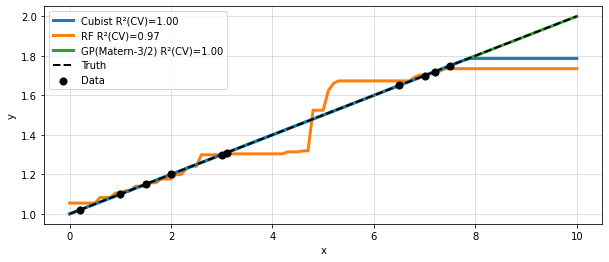

In [4]:
problem = opti.problems.Line1D()
test_1d_problem(problem)

Here's an example where the ground truth is a quadratic model.
Given our ignorance on the measurement noise, all models are reasonable.
The GP again happens to give the best extrapolation which is unusual, because in typical settings with noise included in the kernel, the GP would be less prone to extrapolate and would instead return to the mean.

Looking at the Cubist model we do see som linear modeling in action between the second and fourth data point on the left.
Comparing with the RF, we can see that Cubist will go through every data point, and is hence sensitive to outliers.

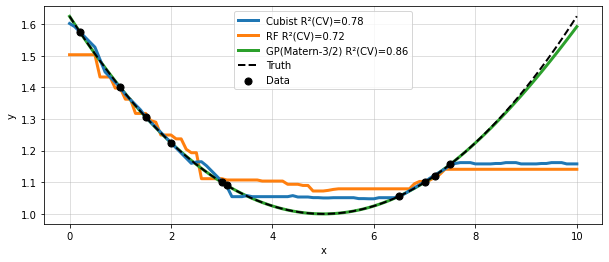

In [5]:
problem = opti.problems.Parabola1D()
test_1d_problem(problem)

Now let's look at sigmoid function, where the transition region is unobserved.
Given this ignorance there a many reasonable transitions possible for a model (RF vs GP).
Here the Cubist model does not do well: For no good reason it models a step that occurs directly after the last observed point on the left.
We can also see the consequence of this odd behaviour in the cross-validation performance.  

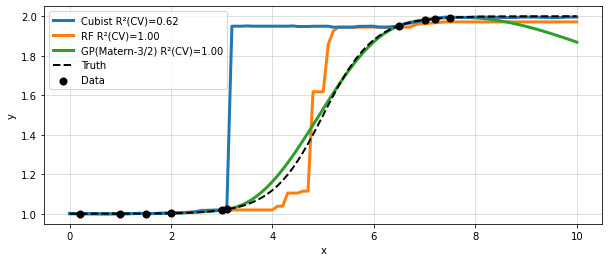

In [6]:
problem = opti.problems.Sigmoid1D()
test_1d_problem(problem)

Next, let's look at a step function with binary outpus, where the transition region is well sampled.
This should be an easy case for a tree-based model, whereas the GP suffers due to its relatively smooth Matern-3/2 kernel.
Both Cubist and RF do rather well, however the Cubist's non-constant prediction in the range $x=3-6$ are rather odd.

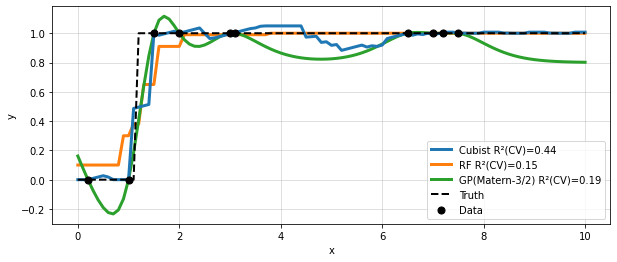

In [7]:
problem = opti.problems.Step1D()
test_1d_problem(problem)

In the final 1D example we can see how a Cubist prediction can be composed of multiple rules / linear models.
Cubist fits a line with a negative slope for the entire range $x = 0 - 8$.
This prediction is then augmented with additional rules to actually fit the data, resulting in a funny sawtooth pattern. 
While this is not harmfull in terms of modeling the data (all 3 model fit well) it's unexpected and inconsistent with Occam's razor.

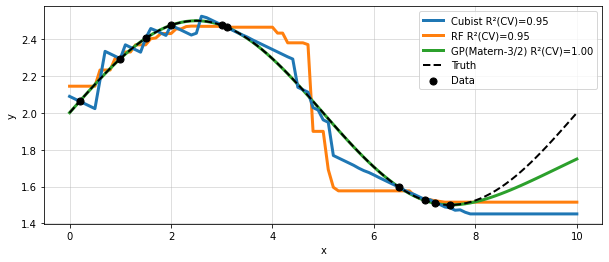

In [8]:
problem = opti.problems.Sinus1D()
test_1d_problem(problem)

### Performance on larger datasets.

Cubist does work on larger datasets in terms of number of data points and features, but it's a lot slower than ensemble methods.
Already on the the California housing dataset with ~20000 entries, the difference between RF and Cubist is huge: 11 s vs 3 min on my machine.

In [14]:
from sklearn import datasets

X, y = datasets.fetch_california_housing(return_X_y=True)
print(X.shape)

(20640, 8)


In [12]:
model = RandomForestRegressor()
%time model.fit(X, y)

Wall time: 11 s


RandomForestRegressor()

In [13]:
model = Cubist()
%time model.fit(X, y)

Wall time: 3min 5s


Cubist()

### Other features

Cubist natively support strings and datetimes so no encoding or conversion is needed here!

In [15]:
problem = opti.problems.BaumgartnerAniline()
problem.data.head()

,catalyst,base,base_equivalents,temperature,residence_time,yield
0,tBuXPhos,DBU,2.183015,30.0,328.717802,0.042833
1,tBuXPhos,BTMG,2.190882,100.0,73.331194,0.959690
2,tBuXPhos,TMG,1.093138,47.5,75.121297,0.031579
3,tBuXPhos,TMG,2.186276,100.0,673.259508,0.766768
4,tBuXPhos,TEA,1.108767,30.0,107.541151,0.072299


In [16]:
X, y = problem.get_XY()
model = Cubist()
model.fit(X, y.ravel())
model.score(X, y.ravel())

0.9991123163365638

Multiple outputs are not supported. 
Printing the rules in a nice way is not yet implemented in the Python wrapper, but the model can already be accessed and parsed if necessary.

In [18]:
problem = opti.problems.Line1D()
model = Cubist()
Xd, yd = problem.get_XY()
model.fit(Xd, yd.ravel())

print("Rules:", model.rules_)
print("Model:", model.model_)

Rules: None
Model: id="Cubist 2.07 GPL Edition 2021-11-14"
prec="2" globalmean="1.39" extrap="0.05" insts="1" nn="1" maxd="0.2" ceiling="1.7865" floor="0.9835"
att="outcome" mean="1.39" sd="0.285074" min="1.02" max="1.75"
att="var0" mean="3.9" sd="2.850732" min="0.2" max="7.5"
entries="1"
rules="1"
conds="0" cover="10" mean="1.390" loval="1.02" hival="1.75" esterr="0.000"
coeff="1" att="var0" coeff="0.1"



The package is certainly nice already in this early stage.
For now, I'm a little bit disappointed by the oddities in the Cubist algorithm, but I might well change my mind.

\bibliography